In [1]:
from tensorflow.contrib import slim
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import os

In [2]:
class autoencoder_slim(object):
    
    def __init__(self, inputs_shape= (50, 50), isTraining= True):
        self.END = {}
        self.learning_rate = 0.01
        self.isTraining = isTraining
        self.inputs_shape = inputs_shape
        self.inputs_size = int(np.prod(self.inputs_shape))
        self.inputs = tf.placeholder(tf.float32, shape= [None] + list(self.inputs_shape), name= 'inputs')
        self.param_conv = dict(kernel_size= 3, stride= 1, padding= 'same', activation_fn= tf.nn.relu)
        self.END = self.network()
        pass
    
    def network(self, num_layers= 1):
        self.END['inputs'] = net = self.inputs
        with tf.name_scope('input_conv'):
            self.END['input_conv'] = net = slim.repeat(net, 2, slim.conv1d, num_outputs= 64, **self.param_conv)
        with tf.name_scope('encoder'):
            self.END['encoder'] = net = slim.repeat(net, 2, slim.conv1d, num_outputs= 128, **self.param_conv)
        with tf.name_scope('code'):
            self.END['code'] = net = slim.repeat(net, 2, slim.conv1d, num_outputs= 2, **self.param_conv)
        #with tf.name_scope('noise'):
        #    self.END['noise'] = tf.random_normal(net.get_shape().as_list())
        #    self.END['z'] = net = net + self.END['noise']
        with tf.name_scope('decoder'):
            self.END['decoder'] = net = slim.repeat(net, 2, slim.conv1d, num_outputs= 64, **self.param_conv)
        with tf.name_scope('output_conv'):
            self.END['output_conv'] = net = slim.repeat(net, 2, slim.conv1d, num_outputs= list(self.inputs_shape)[-1], **self.param_conv)
        self.END['outputs'] = net = tf.reshape(net, [-1] + list(self.inputs_shape), name= 'outputs')
        if self.isTraining:
            with tf.name_scope('loss'):
                self.END['loss'] = loss = tf.reduce_sum(self.inputs * tf.log(self.END['outputs'] + 1e-9) + (1 - self.inputs) * tf.log((1 - self.END['outputs'] + 1e-9)))
                tf.summary.scalar("Loss", loss)
            with tf.name_scope('optimizer'):
                self.END['optimizer'] = optimizer = tf.train.AdagradOptimizer(self.learning_rate).minimize(loss)
        return self.END

In [3]:
model_dir = os.path.join(os.getcwd(), "model")
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
MODEL_NAME = "CNN.ckpt"
LOG_DIR = "TensorBoard/"
SAVE_PATH = os.path.join(model_dir, MODEL_NAME)
Training = True

Name = 'Bus'
cur_dir = os.getcwd()
dataset = os.path.join(cur_dir, 'dataset')
dataset_dir = os.path.join(dataset, Name)
subimages = os.path.join(dataset_dir, 'SubImages')
images_path = []
if os.path.exists(subimages):
    images_name = os.listdir(subimages)
    for name in images_name:
        images_path.append(os.path.join(subimages, name))

In [4]:
# Build Net
inputs_shape = (50, 50)
auto = autoencoder_slim(inputs_shape= inputs_shape)

In [5]:
SAVER = tf.train.Saver()
init = tf.global_variables_initializer()
cfg = tf.ConfigProto(log_device_placement= False, allow_soft_placement= True)
cfg.gpu_options.per_process_gpu_memory_fraction = 0.8
cfg.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config= cfg)
sess.run(init)

In [17]:
inp = auto.inputs
if Training:
    img = cv2.imread(images_path[0])
    img_shape = img.shape
    img = cv2.resize(img, (inputs_shape[1], inputs_shape[0]), interpolation= cv2.INTER_LANCZOS4)
    out_img = np.asarray(img)
    for i in range(3):
        inp_img = np.reshape(img[:, :,i], [1] + list(inputs_shape))
        inp_img = inp_img / 255
        sess.run(auto.END['optimizer'], feed_dict= {inp: inp_img})
        loss = auto.END['loss'].eval(feed_dict= {inp: inp_img})
        print (f"Loss : {loss}")
        inp_conv = auto.END['input_conv'].eval(feed_dict= {inp: inp_img})
        enc = auto.END['encoder'].eval(feed_dict= {inp: inp_img})
        code = auto.END['code'].eval(feed_dict= {inp: inp_img})
        dec = auto.END['decoder'].eval(feed_dict= {inp: inp_img})
        oup_conv = auto.END['output_conv'].eval(feed_dict= {inp: inp_img})
        out_img[:, :, i] = oup_conv

(1, 50, 50)
Loss : -20441.34765625
(1, 50, 50)
Loss : -22123.59375
(1, 50, 50)
Loss : -24951.7890625


In [18]:
print (f"Input Conv : {inp_conv.shape}\nEncoder : {enc.shape}\nCode : {code.shape}\nDecoder : {dec.shape}\nOutput Conv : {oup_conv.shape}")

Input Conv : (1, 50, 64)
Encoder : (1, 50, 128)
Code : (1, 50, 2)
Decoder : (1, 50, 64)
Output Conv : (1, 50, 50)


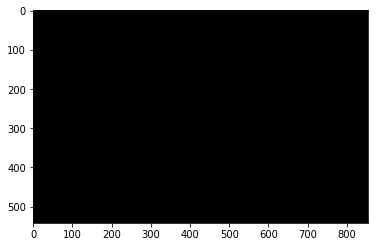

In [19]:
out_img = np.reshape(out_img * 255, list(inputs_shape) + [3])
out_img = cv2.resize(out_img, (img_shape[1], img_shape[0]), interpolation= cv2.INTER_LANCZOS4).astype(np.uint8)
plt.imshow(out_img)
plt.show()

In [23]:
inp = auto.inputs
out_imgs = []
losses = []
codes = []
if Training:
    num_iterations = 1000
    log_iterations = 100
    for i in range(num_iterations):
        img = cv2.imread(images_path[0])
        img_shape = img.shape
        img = cv2.resize(img, (inputs_shape[1], inputs_shape[0]), interpolation= cv2.INTER_LANCZOS4)
        out_img = np.asarray(img)
        for j in range(3):
            inp_img = np.reshape(img[:, :,j], [1] + list(inputs_shape))
            inp_img = inp_img / 255
            sess.run(auto.END['optimizer'], feed_dict= {inp: inp_img})
            if i % log_iterations == 0:
                loss = auto.END['loss'].eval(feed_dict= {inp: inp_img})
                print (f"Loss : {loss}")
                code = auto.END['code'].eval(feed_dict= {inp: inp_img})
                codes.append(code)                                      
                losses.append(loss)
            oup_conv = auto.END['output_conv'].eval(feed_dict= {inp: inp_img})
        out_img[:, :, j] = oup_conv
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter(LOG_DIR, graph = sess.graph)

Loss : -20441.34765625
Loss : -22123.59375
Loss : -24951.7890625
Loss : -20441.34765625
Loss : -22123.59375
Loss : -24951.7890625
Loss : -20441.34765625
Loss : -22123.59375
Loss : -24951.7890625
Loss : -20441.34765625
Loss : -22123.59375
Loss : -24951.7890625
Loss : -20441.34765625
Loss : -22123.59375
Loss : -24951.7890625
Loss : -20441.34765625
Loss : -22123.59375
Loss : -24951.7890625
Loss : -20441.34765625
Loss : -22123.59375
Loss : -24951.7890625
Loss : -20441.34765625
Loss : -22123.59375
Loss : -24951.7890625
Loss : -20441.34765625
Loss : -22123.59375
Loss : -24951.7890625
Loss : -20441.34765625
Loss : -22123.59375
Loss : -24951.7890625


In [24]:
sess.close()